In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] =  ['SimHei']
plt.rcParams['axes.unicode_minus'] =  False

In [2]:
# 加载
def get_files(file_path='./data1/'):
    file_names = os.listdir(file_path)
    # 1 获取单个工作簿中所有子表名称
    f = pd.ExcelFile(file_path + file_names[0], engine='openpyxl')
    sheet_names = f.sheet_names

    # 2 循环获取数据
    # 一类数据为一个键值对
    all_data = {sheet_name: pd.DataFrame([]) for sheet_name in sheet_names}

    for file_name in file_names:  # 循环11个文件
        for sheet_name in sheet_names:  # 循环4个子表
            # 读取数据
            tmp = pd.read_excel(file_path + file_name, sheet_name=sheet_name, engine='openpyxl')
            # 添加字段
            tmp['yd_type'] = file_name.split('.')[0]
            # 拼接数据
            all_data[sheet_name] = pd.concat([all_data[sheet_name], tmp])
    return all_data

In [3]:
all_data_test = get_files('./data/附件2/')

In [4]:
# 预处理
def fix_na(data):
    tmp2 = data.copy()
    # 1 时间格式转换
    tmp2['time'] = pd.to_datetime(data['time'])
    # 2 时间作为索引
    tmp2 = tmp2.set_index('time')
    # 3 重采样
    tmp3 = tmp2.resample('S').max()
    # 4 缺失值处理
    ind = tmp3.iloc[:,0].isna()
    ind2 = pd.Series(ind[ind].index, index= ind[ind].index).diff().dt.seconds
    ind3 = ind2.loc[ind2 == 1].index
    # 删除
    tmp4 = tmp3.drop(ind3)
    tmp_res = tmp4.fillna(method='ffill')
    return tmp_res

In [5]:
# 构建
all_data_fix_na_test = {i:pd.DataFrame() for i in ['设备数据', '周波数据', '谐波数据']}
# 循环处理
for i in all_data_test['设备数据']['yd_type'].unique():
    for j in ['设备数据', '周波数据', '谐波数据']:
        # 提取对应数据
        tmp = all_data_test[j].loc[all_data_test[j]['yd_type']==i,:]
        # 处理
        all_data_fix_na_test[j] = pd.concat([all_data_fix_na_test[j],fix_na(tmp)])

for i in ['设备数据', '周波数据', '谐波数据']:
    print(i, all_data_test[i].shape, all_data_fix_na_test[i].shape)

设备数据 (505, 11) (526, 10)
周波数据 (505, 259) (526, 258)
谐波数据 (505, 103) (526, 102)


In [6]:
# 特征构建
def get_feature(data):
    feature1 =data['设备数据'][['IC','UC','PC','QC','PFC','label','yd_type']]

    tmp = data['周波数据']
    cols = [i for i in tmp.columns if 'UC' not in i]
    feature2 = tmp[cols]
    feature21 = pd.DataFrame([], columns=['波峰','波谷'])
    from sklearn.cluster import KMeans
    for i in range(len(feature2)):
        d = feature2.iloc[i,:-2]
        model = KMeans(n_clusters=2)
        model.fit(d.values.reshape((-1,1)))
        tmp = model.cluster_centers_
        feature21.loc[d.name, '波峰'] = tmp.max() # 波峰
        feature21.loc[d.name, '波谷'] = tmp.min() # 波谷
        feature21.loc[d.name,'波峰_num'] = sum(model.labels_ == tmp.argmax())
        feature21.loc[d.name,'波谷_num'] = sum(model.labels_ == tmp.argmin())

    tmp = data['谐波数据']
    cols = [i for i in tmp.columns if 'UC' not in i]
    feature3 = tmp[cols]
    tmp = feature3.drop(['label','yd_type'],axis=1)
    from scipy import stats
    feature31 = tmp.apply(lambda d: [d.max(), d.mean(), d.std(), d.kurt(),
                       stats.skew(d), d.median(), d.quantile(0.9)], axis=1 )
    feature31_new = pd.DataFrame(list(feature31.values),index=feature31.index,
                                 columns=['最大值','均值','标准差','峰度','偏度','中位数','0.9分位数'])

    data_feature_fe = pd.concat([feature1,feature21, feature31_new],axis=1)
    return data_feature_fe

feature_test = get_feature(all_data_fix_na_test)

In [7]:
# 拆分
x, y = feature_test.drop(['label','yd_type'], axis=1), feature_test['label']
print(x.shape, y.shape)

(526, 16) (526,)


In [8]:
# 加载数据标准化模型
from joblib import load
scale_test =load('scale_ss')
x_ss = scale_test.transform(x)

In [9]:
# 加载KNN模型预测
model_test = load('model_knn')
y_pred = model_test.predict(x_ss)
y_pred

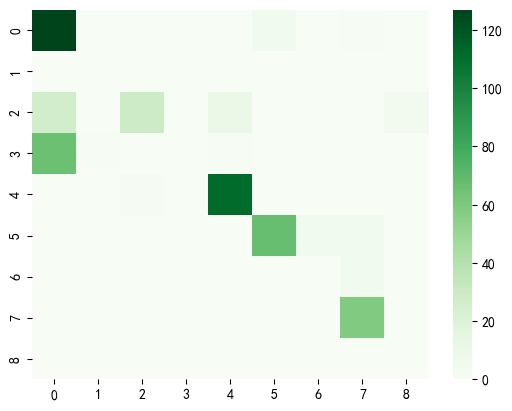

In [10]:
# 模型评估
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
sns.heatmap(confusion_matrix(y, y_pred),cmap='Greens')
plt.show()

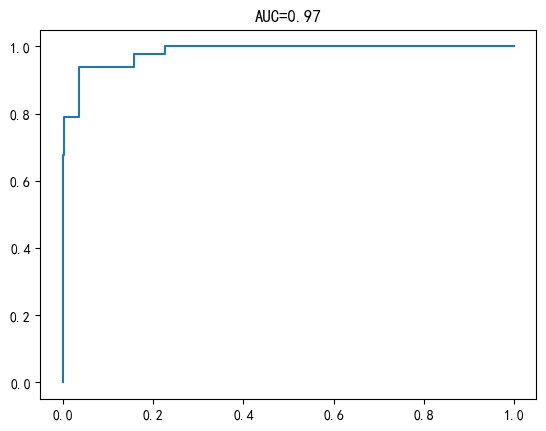

In [11]:
# 输出模型评价参数并绘制AUC图像
plt.figure()
y_scores = model_test.predict_proba(x_ss)
y_scores
fpr, tpr, _  = roc_curve(y==0, y_scores[:,0])
plt.step(fpr, tpr)
plt.title(f'AUC={auc(fpr,tpr):.2f}')
plt.show()

In [12]:
# 设备用电量预测
data_res_all = pd.DataFrame()
for yd_type in all_data_test['设备数据']['yd_type'].unique():
    # 提取特征中的设备数据
    tmp = feature_test.loc[feature_test['yd_type']==yd_type, :]
    # 计算设备用电量
    data_res = pd.DataFrame(tmp['PC']*100/3600) # 计算用电量
    # 改名字
    data_res.columns = ['用电量']
    # 根据相同的设备添加预测出来的类型信息
    data_res['label'] = y_pred[feature_test['yd_type'] == yd_type]
    # 对数据进行按秒抽样
    data_res2 = data_res.resample('S').fillna('bfill')
    # 合并两个设备的数据
    data_res_all = pd.concat([data_res2,data_res_all])

In [13]:
data_res_all

,用电量,label
2018-01-21 18:49:14,0.638889,0.0
2018-01-21 18:49:15,0.611111,0.0
2018-01-21 18:49:16,0.666667,0.0
2018-01-21 18:49:17,0.638889,0.0
2018-01-21 18:49:18,0.638889,0.0
...,...,...
2018-01-16 16:04:45,0.055556,0.0
2018-01-16 16:04:46,0.083333,0.0
2018-01-16 16:04:47,0.111111,0.0
2018-01-16 16:04:48,0.083333,0.0
